In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("data/Chest_xray_Corona_Metadata.csv")
data

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,Normal
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,Normal
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,Normal
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,Normal
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,Normal
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [2]:
from typing import Optional, Sequence

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import torchvision
from PIL import ImageFile
import matplotlib.pyplot as plt
import cv2
from torch.optim.lr_scheduler import StepLR
import random
import copy
from torch.utils.data import random_split
import torchvision
from torch.autograd import Variable
import torch.utils.data
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch import Tensor


# Setting path

In [3]:
import sys
print(sys.version)
data_dir = os.getcwd()
# data_dir = '/home/ilkay/Documents/mahyar/ChestXrays'
train_dir = data_dir + '/train1' #contains training images
test_dir = data_dir + '/test1'
val_dir = data_dir + '/val1'

print(train_dir)

3.7.7 (default, May  7 2020, 21:25:33) 
[GCC 7.3.0]
/home/ilkay/Documents/mahyar/ChestXrays/train1


# Class weighting

In [4]:
label = np.load('label.npy')
labels_unique, counts = np.unique(label, return_counts = True)
print('Unique labels : {}'.format(labels_unique))
print('Counting labels : {}'.format(counts))

class_weights = [1/c for c in counts]
print('class_withts: ', class_weights)
class_weights = torch.FloatTensor(class_weights)

n_classes = len(labels_unique)
print('n_classes: ', n_classes)

Unique labels : [0 1 2 3]
Counting labels : [1341 2534 1346   71]
class_withts:  [0.0007457121551081282, 0.0003946329913180742, 0.0007429420505200594, 0.014084507042253521]
n_classes:  4


# Data loader

In [5]:
image_size = 224
train_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.RandomVerticalFlip(p=0.5),
            torchvision.transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

test_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
train_dataset = ImageFolder(train_dir, train_transforms)
test_dataset = ImageFolder(test_dir, test_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

In [6]:
batch_size = 8 

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# Loading the model

In [7]:
# Load ResNet-50 and DenseNet-121 model seperately here
import torchvision.models as models
resnet = models.resnet50(pretrained=True)
model = resnet
# for param in model.parameters():
#     param.requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
# resnet = models.resnet50(pretrained=True)
# model = resnet
# model.classifier = nn.Sequential(
#     nn.Linear(2048, 100), nn.ReLU(), nn.Linear(100, n_classes))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Multi calss accuracy implementation

In [8]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

# Hyperparameter setup

In [9]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-3
regularization_rate = 0
# n_epochs = 1
use_gpu = True
###

# FL = FocalLoss(gamma = 2)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
FL = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8)
# fl = FocalLoss()
# criteria = fl()

In [10]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

# Training

In [11]:

from tqdm.notebook import tqdm
n_epochs = 20
learning_rate = 1e-3

total_step = len(train_loader)

print("Begin training.")
for e in tqdm(range(1, n_epochs+1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    if use_gpu:
        model.cuda()
        FL.cuda()

#     for epoch in range(n_epochs):
    train_epoch_loss = 0
    train_epoch_acc = 0
    scheduler.step()
    print('Epoch:', e,'LR:', scheduler.get_lr())
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        img, label = data
        images = img.to(device)
        labels = label.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        train_loss = FL(outputs, labels)
        train_acc = multi_acc(outputs, labels)
       
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        # To monitor the training process we print or log some useful values 
#         if (ix+1) % 10 == 0:
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train_acc:{:.4f}' 
#                    .format(epoch+1, n_epochs, ix+1, train_loss.item()), train_acc)
#   
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for iy, data_ in enumerate(val_loader):
            img_, label_ = data_
            images_ = img_.to(device)
            labels_ = label_.to(device)

            outputs_ = model(images_)
            val_loss = FL(outputs_, labels_)

#             _, predicted = torch.max(outputs_.data, dim = 1)
            val_acc = multi_acc(outputs_, labels_)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
print("End training") 

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 LR: [0.001]


/home/ilkay/miniconda3/envs/covid/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/ilkay/miniconda3/envs/covid/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 001: | Train Loss: 0.86637 | Val Loss: 0.92976 | Train Acc: 69.231| Val Acc: 69.643
Epoch: 2 LR: [0.001]
Epoch 002: | Train Loss: 0.66998 | Val Loss: 1.03688 | Train Acc: 84.478| Val Acc: 69.643
Epoch: 3 LR: [0.001]
Epoch 003: | Train Loss: 0.60509 | Val Loss: 0.94442 | Train Acc: 87.363| Val Acc: 61.607
Epoch: 4 LR: [0.001]
Epoch 004: | Train Loss: 0.58706 | Val Loss: 0.71399 | Train Acc: 89.286| Val Acc: 71.429
Epoch: 5 LR: [0.001]
Epoch 005: | Train Loss: 0.56066 | Val Loss: 0.94254 | Train Acc: 91.209| Val Acc: 58.036
Epoch: 6 LR: [0.001]
Epoch 006: | Train Loss: 0.57073 | Val Loss: 0.81656 | Train Acc: 89.148| Val Acc: 75.000
Epoch: 7 LR: [0.001]
Epoch 007: | Train Loss: 0.54493 | Val Loss: 0.59108 | Train Acc: 91.896| Val Acc: 87.500
Epoch: 8 LR: [0.001]
Epoch 008: | Train Loss: 0.52308 | Val Loss: 0.61287 | Train Acc: 92.445| Val Acc: 80.357
Epoch: 9 LR: [0.001]
Epoch 009: | Train Loss: 0.50711 | Val Loss: 0.69982 | Train Acc: 92.582| Val Acc: 81.250
Epoch: 10 LR: [0.001]


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

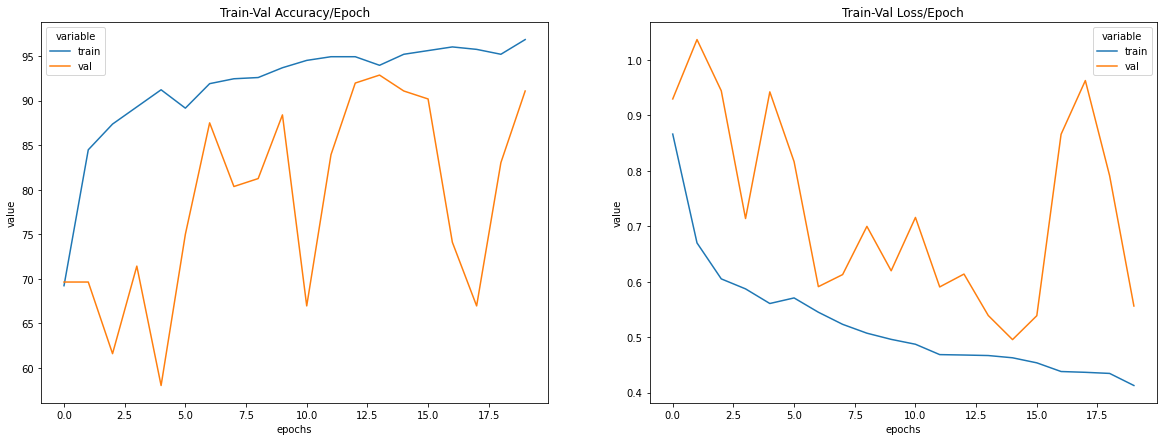

In [16]:
import seaborn as sns

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [17]:
y_pred_list = []
test_epoch_loss = 0
test_epoch_acc = 0
with torch.no_grad():
    model.eval()
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        y_test_pred = model(X_batch)
        test_loss = FL(y_test_pred, Y_batch)

        test_acc = multi_acc(y_test_pred, Y_batch)
        test_epoch_loss += test_loss.item()
        test_epoch_acc += test_acc.item()
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
print('average_acc_train: ',np.array(accuracy_stats['train']).sum()/20)
# accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
print('average_acc_val: ',np.array(accuracy_stats['val']).sum()/20)


average_acc_train:  91.71016483516485
average_acc_val:  78.75000000000001


In [19]:
print(test_epoch_acc/len(test_loader))

82.6923076923077
